# Visualize the Graphical Structure of Countries by their Amenity Distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Get population
df_population = pd.read_csv('data/economic_measurements.csv', index_col='country')
df_population = df_population[['Population']]

# Get amenity counts
df_amenity = pd.read_csv('data/country_amenity_counts.csv')
df_amenity.set_index('country', inplace=True)
df_amenity.drop(columns='country_code', inplace=True)

# Replace 0 values with 0.1 (important for logarithmic representation)
df_amenity = df_amenity.applymap(lambda x: 0.1 if x == 0 else float(x))

# Normalize amenities of each country by their population
df_amenity_normalized = df_amenity.apply(
    lambda row: row / df_population['Population'].loc[row.name], axis=1)

df_amenity.head()

df_amenity = df_amenity.T
df_amenity_normalized = df_amenity_normalized.T

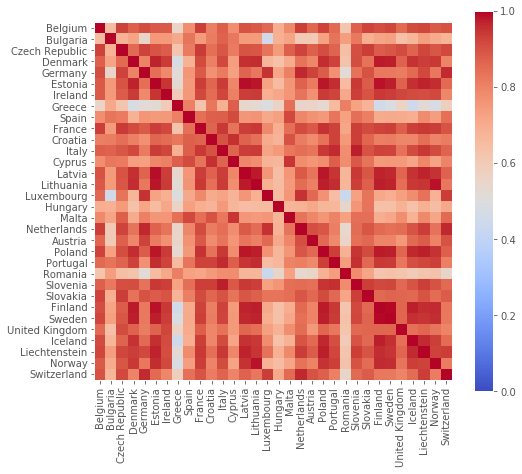

In [3]:
df_corr = df_amenity_normalized.corr()

plt.figure(figsize=(8, 7))
plt.imshow(df_corr, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
locs = range(len(df_corr.columns))
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False);

In [4]:
from sklearn import cluster, covariance, manifold

X = df_amenity_normalized.values
X -= X.mean(axis=0)
X /= X.std(axis=0)

edge_model = covariance.GraphLassoCV()
edge_model.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: overflow encountered in multiply
  * coefs)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: overflow encountered in multiply
  * coefs)
/home/kubuntu-user/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

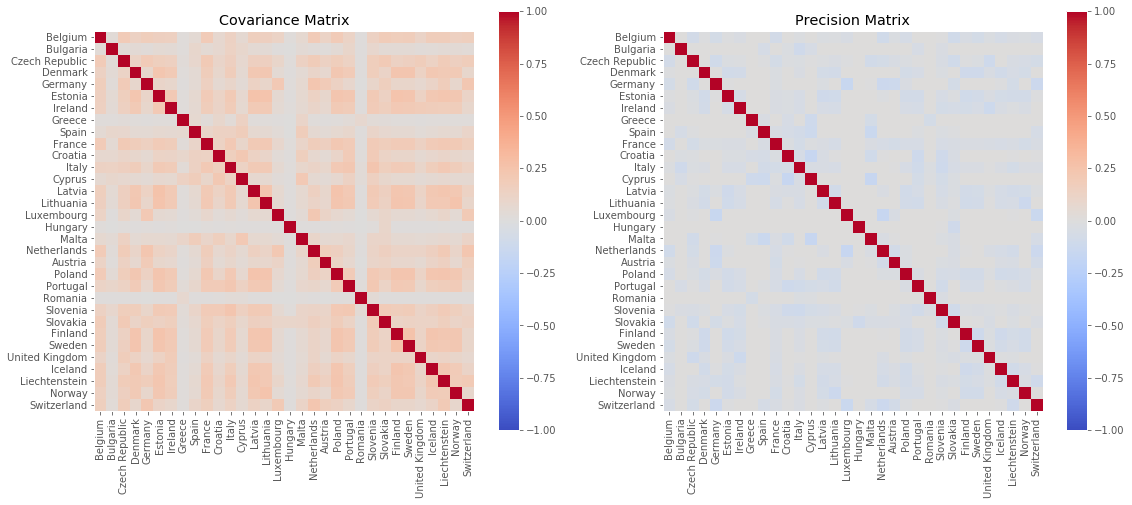

In [5]:
locs = range(len(df_amenity_normalized.columns))
labels = df_amenity_normalized.columns

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(edge_model.covariance_, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Covariance Matrix')
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(edge_model.precision_, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Precision Matrix')
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False)
plt.colorbar()
plt.tight_layout();

In [6]:
names = df_amenity_normalized.columns

centers, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Bulgaria
Cluster 2: Belgium, Czech Republic, France, Slovakia, United Kingdom
Cluster 3: Germany, Luxembourg, Netherlands, Austria, Switzerland
Cluster 4: Denmark, Estonia, Ireland, Italy, Latvia, Lithuania, Poland, Portugal, Slovenia, Finland, Sweden, Iceland, Liechtenstein, Norway
Cluster 5: Greece, Spain, Croatia, Cyprus, Malta
Cluster 6: Hungary
Cluster 7: Romania


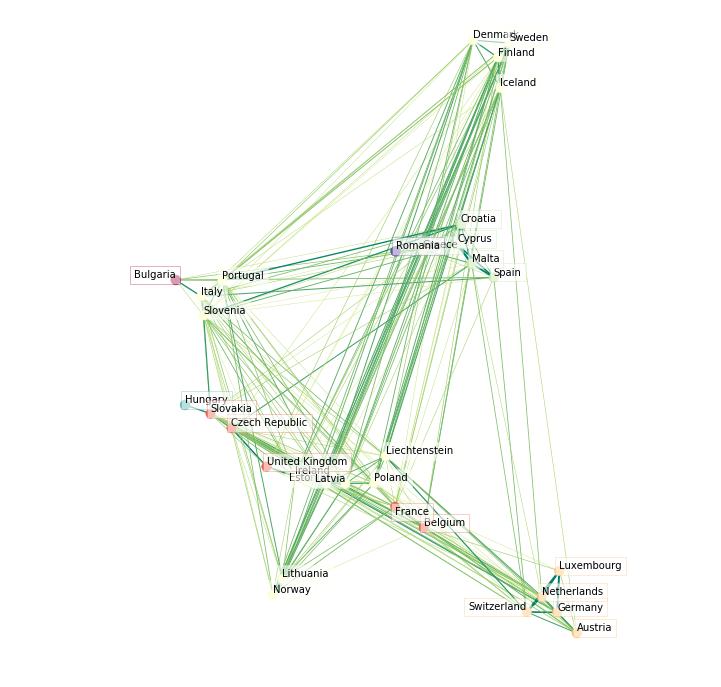

In [7]:
import draw_utils
if 'draw_utils' in locals():
    import importlib
    importlib.reload(draw_utils)

tsne = manifold.TSNE(n_components=2, perplexity=2, n_iter=1000)
embedding = tsne.fit_transform(X.T)

centers, labels = cluster.affinity_propagation(edge_model.covariance_)

plt.figure(figsize=(12, 12))
draw_utils.visualize_graph(embedding, edge_model.precision_, names, labels)